In [1]:
import time
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import astropy.units as u
from astropy import stats
from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector

In [ ]:
mmirs = WFSFactory(wfs="mmirs", nzern=36)

In [ ]:
mmirs.modes['mmirs1']['reference']['figure'].show()

In [ ]:
print(mmirs.modes['mmirs1']['reference']['fwhm'])

spot = mmirs.modes['mmirs1']['reference']['spot']
model = Gaussian2D(amplitude=spot.max(), x_mean=spot.shape[1]/2, y_mean=spot.shape[0]/2) + Polynomial2D(degree=0)
#model = Gaussian2D(amplitude=spot.max(), x_mean=spot.shape[1]/2, y_mean=spot.shape[0]/2)
fitter = LevMarLSQFitter()
y, x = np.mgrid[:spot.shape[0], :spot.shape[1]]
fit = fitter(model, x, y, spot)
fig, ax = plt.subplots()
ax.imshow(mmirs.modes['mmirs1']['reference']['spot'] - fit(x, y))
fig.show()

In [ ]:
mmirs_file = "/Users/tim/MMT/wfsdat/20170416/rawdata/mmirs_wfs_%04d.fits" % 350
results = mmirs.measure_slopes(mmirs_file, plot=True)
results['seeing']

In [ ]:
results['figures']['pupil_center'].show()

In [ ]:
zresults = mmirs.fit_wavefront(results, plot=True)
zvec = zresults['zernike']
print(zresults['residual_rms'])
#zvec.normalize()
print(zvec)
zresults['resid_plot'].show()

In [ ]:
zplot = zvec.copy()
zplot.ignore('Z02')
zplot.ignore('Z03')
mfig = zplot.plot_map()
mfig.show()
zplot.peak2valley

In [ ]:
zvec.units = u.nm
f = zvec.bar_chart(residual=zresults['residual_rms'])
f.show()

In [ ]:
torig = mmirs.telescope.bending_forces(zvec)
torig.show_in_notebook()

In [ ]:
force_fig = mmirs.telescope.plot_forces(torig)
force_fig.show()

In [ ]:
t, m1foc = mmirs.correct_primary(zv=zvec)
print(m1foc)
t.show_in_notebook()

In [ ]:
new_force_fig = mmirs.telescope.plot_forces(t)
new_force_fig.show()

In [ ]:
zpsf = zvec.copy()
psf, psf_fig = mmirs.telescope.psf(zpsf, plot=True)
psf_fig.show()

# F/9 Dev Section

In [ ]:
plt.close('all')

In [ ]:
f9wfs = WFSFactory(wfs="f9", nzern=36)
f9_file = "/Users/tim/MMT/wfsdat/20170318/AST45_p1000_0000.fits"
results = f9wfs.measure_slopes(f9_file, 'blue', plot=True)
results['figures']['slopes'].show()
# 265 258
# ref 240 259.5

In [ ]:
zresults = f9wfs.fit_wavefront(results, plot=True)
print(zresults['residual_rms'])
print(zresults['zernike'])
zresults['resid_plot'].show()

In [ ]:
zv = zresults['zernike']
print(zv.rms)
zv.ignore('Z02')
zv.ignore('Z03')
f = zv.plot_map()
f.show()

In [ ]:
bc = zv.bar_chart()
bc.show()

In [ ]:
psf, psf_fig = f9wfs.telescope.psf(zv, fov=1.0)
psf_fig.show()

# F/5 Dev Section

In [2]:
plt.close('all')
f5wfs = WFSFactory(wfs="f5", nzern=36)

<IPython.core.display.Javascript object>


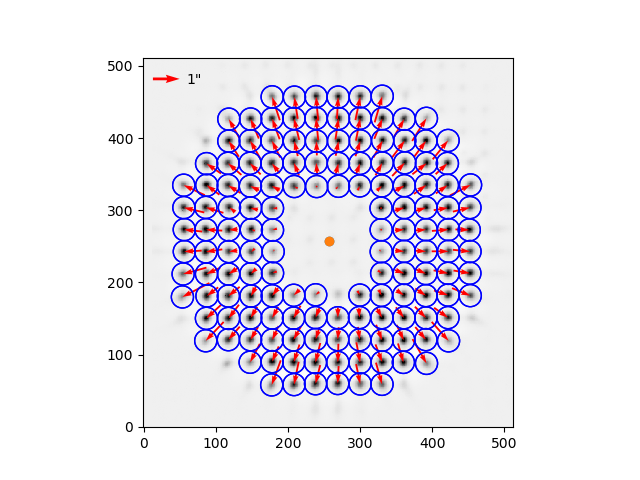

In [17]:
f5_file = "/Users/tim/MMT/wfsdat/20170505/auto_wfs_0051_ave.fits"
results = f5wfs.measure_slopes(f5_file, 'hecto', plot=True)
results['figures']['slopes'].show()

Fringe Coefficients
 Z02:       193 nm 	 X Tilt (1, 1)
 Z03:      -112 nm 	 Y Tilt (1, -1)
 Z04:      -202 nm 	 Defocus (2, 0)
 Z05:      -604 nm 	 Primary Astig at 45° (2, -2)
 Z06:      -386 nm 	 Primary Astig at 0° (2, 2)
 Z07:       132 nm 	 Primary Y Coma (3, -1)
 Z08:       250 nm 	 Primary X Coma (3, 1)
 Z09:      4.67 nm 	 Y Trefoil (3, -3)
 Z10:     -44.8 nm 	 X Trefoil (3, 3)
 Z11:      59.3 nm 	 Primary Spherical (4, 0)
 Z12:      84.5 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:       -68 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:      3.24 nm 	 X Tetrafoil (4, 4)
 Z15:     -13.1 nm 	 Y Tetrafoil (4, -4)
 Z16:     -80.2 nm 	 Secondary X Coma (5, 1)
 Z17:      15.7 nm 	 Secondary Y Coma (5, -1)
 Z18:       165 nm 	 Secondary X Trefoil (5, 3)
 Z19:       141 nm 	 Secondary Y Trefoil (5, -3)
 Z20:       -23 nm 	 X Pentafoil (5, 5)
 Z21:      13.6 nm 	 Y Pentafoil (5, -5)
 Z22:       414 nm 	 Secondary Spherical (6, 0)
 Z23:       135 nm 	 Tertiary Astigmatism at 45° (6, 

<IPython.core.display.Javascript object>


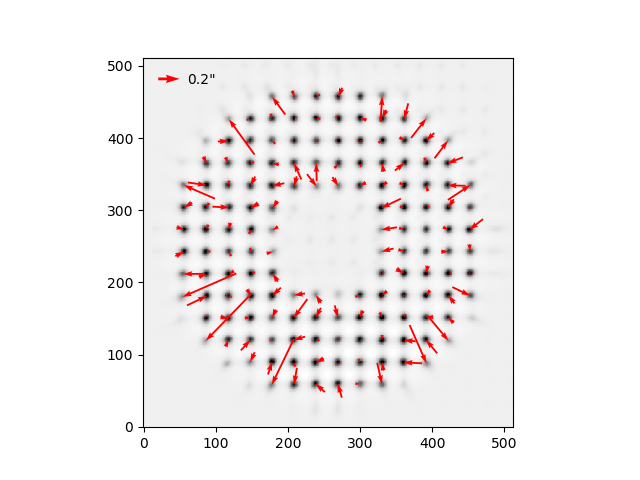

In [18]:
zresults = f5wfs.fit_wavefront(results, plot=True)
zv = zresults['zernike']
print(zv)
print(zv.rms)
zresults['resid_plot'].show()

In [ ]:
f5wfs.modes['hecto']['reference']['fwhm']

<IPython.core.display.Javascript object>


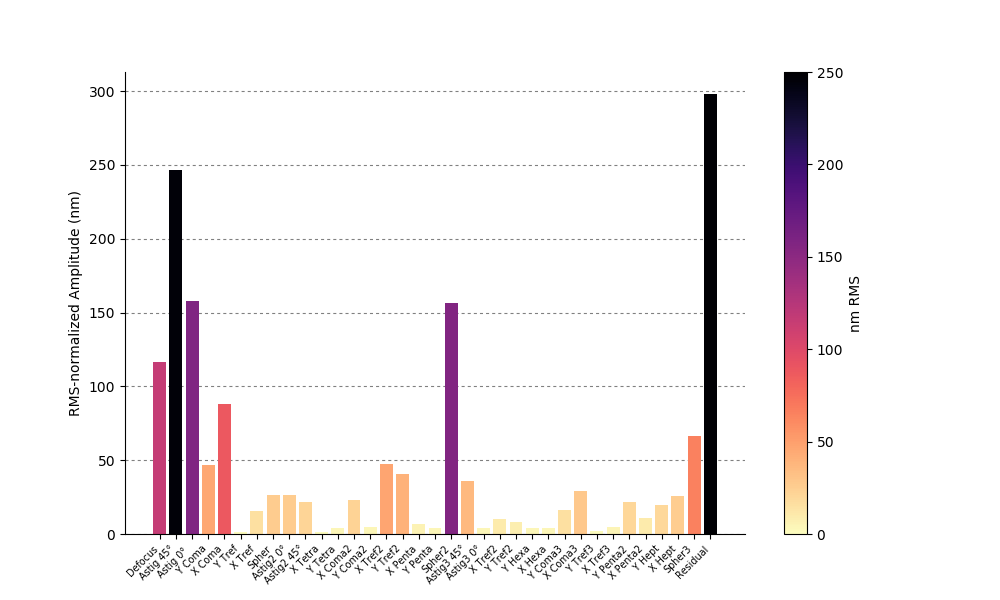

<Quantity 298.08649197220484 nm>

In [19]:
zf = zv.bar_chart(residual=zresults['residual_rms'])
zf.show()
zresults['residual_rms']

In [ ]:
zv.ignore('Z02')
zv.ignore('Z03')
zv.ignore('Z04')
print(zv.rms)
mf = zv.plot_map()
mf.show()

# Scratch space

In [ ]:
cen = center_pupil(subt, pup, plot=True)
print(cen)
plt.show()

In [ ]:
from astropy.io import ascii

In [ ]:
t = f9wfs.telescope
m = t.zern_map

In [ ]:
z = np.loadtxt("/Users/tim/MMT/wfsdat/20170110/mmirs_wfs_0375.dao.sub.zrn.cor")
z1 = np.loadtxt("/Users/tim/MMT/wfsdat/20170110/mmirs_wfs_0375.dao.av.zrn")

In [ ]:
z1 - z

In [ ]:
Z = ZernikeVector(coeffs=z, zmap=m)

In [ ]:
Z

In [ ]:
from astropy.table import Table
from astropy.io import ascii

In [ ]:
t = ascii.read("/Users/tim/MMT/mmtwfs/mmtwfs/data/mmirszernfield.tab")

In [ ]:
t

In [ ]:
np.interp(0.12, t['field_r'], t['Z01'])

In [ ]:
range(4, 11)

In [ ]:
for i in range(4, 12):
    print("Z%02d" % i)

In [ ]:
np.max(1, 2)

In [ ]:
6.75 + 20.30 + 242.15 + 430.51

In [ ]:
13296 - (973.15/.575) - 1025.8

In [ ]:
23*6 + 12*6

In [ ]:
58.69*12

In [ ]:
210+16+69.5+704.28

In [ ]:
2225.37 - (977.15 + 999.78 + 699.71)

In [ ]:
103212.81+341.47-451.27+9632.5

In [ ]:
7324.5+3951.34

In [ ]:
112735.51 - (11275.84 + 7245.8 + 56) - 12150

In [ ]:
4050*3

In [ ]:
3000*.05

In [ ]:
28910/98610

In [ ]:
ai = [247.68, 252.69, 257.79, 261.79, 266.88, 696.98, 280.11, 261.96, 261.96, 261.92, 261.96]
pep = [146.43, 147.28, 145.18, 142.83, 140.7, 138.47, 136.4, 134.18, 132.18, 129.89, 128.12, 126.22]

In [ ]:
0.2* (28910/98610 * (np.sum(ai) + np.sum(pep)))

In [ ]:
len(pep)

In [ ]:
12049 - (290.81 + 850)

In [ ]:
18577.64-7324.5

In [ ]:
110940.01-11253.14 - 9600

In [ ]:
0.032 * 90086.87 + 4226.63

In [ ]:
x = 1920 * 5.86e-3 * u.mm

y = 1200 * 5.86e-3 * u.mm

In [ ]:
np.sqrt(x**2 + y**2)

In [ ]:
np.max((1, 2))

In [ ]:
mmirs.pup_size

In [ ]:
mmirs.modes['mmirs2']['reference']['sigma']

In [ ]:
sigma = results['fwhm'] * stats.funcs.gaussian_fwhm_to_sigma

wave = 650 * u.nm
wave = wave.to(u.m).value  # r_0 equation expects meters so convert
# calculate the physical size of each aperture.
ref = mmirs.modes['mmirs2']['reference']
apsize_pix = np.max((ref['xspacing'], ref['yspacing']))
d = mmirs.telescope.diameter * apsize_pix / mmirs.pup_size
d = d.to(u.m).value  # r_0 equation expects meters so convert

# we need to deconvolve the instrumental spot width from the measured one
ref_sigma = ref['sigma']
if sigma > ref_sigma:
    corr_sigma = np.sqrt(sigma**2 - ref_sigma**2)
else:
    corr_sigma = 0.0
corr_sigma *= mmirs.pix_size.to(u.rad).value  # r_0 equation expects radians so convert
# this equation relates the motion within a single aperture to the characteristic scale size of the
# turbulence, r_0.
r_0 = ( 0.179 * (wave**2) * (d**(-1./3.))/corr_sigma**2 )**0.6
print(r_0)
# this equation relates the turbulence scale size to an expected image FWHM at the given wavelength.
raw_seeing = u.rad * 0.98 * wave / r_0
raw_seeing = raw_seeing.to(u.arcsec)


In [ ]:
"{0.value:0.2f}{0.unit:unicode}".format(raw_seeing)

In [ ]:
np.sqrt(sigma**2 - ref_sigma**2)

In [ ]:
def_mask = ['Z02', 'Z03', 'Z04']
mask = ['Z04', 'Z10']
def_mask.extend(mask)
mask = list(set(def_mask))
mask

In [ ]:
f = ZernikeVector()

In [ ]:
mmirs.telescope.bending_forces(zv=f)

In [ ]:
z = ZernikeVector(Z07=500*u.nm)
z.plot_map()
plt.show()

In [ ]:
-z['Z08']

In [ ]:
xc, yc = 245, 270
xcen, ycen = 255, 255
dx = xc - xcen
dy = yc - ycen
dr, phi = cart2pol([dx, dy])

In [ ]:
derot_phi = phi - u.Quantity(225*u.deg, u.rad).value
pol2cart([dr, derot_phi])

In [ ]:
u.Quantity(225*u.deg, u.rad).value

In [ ]:
dx, dy

In [ ]:
t = mmirs.telescope
zv = ZernikeVector(Z05=1000, Z11=250)
force, focus = t.correct_primary(zv)
f1 = focus.copy()
uforce, ufocus = t.undo_last()
print(ufocus)
print(f1)
assert(ufocus == -1 * f1)

In [ ]:
focus.copy()

In [ ]:
np.allclose(np.zeros(2), 0.0)

In [ ]:
s = "offset_inc wfs z 200.3"
assert("200.3" in s)

In [ ]:
fig, ax = plt.subplots()

In [ ]:
ax.imshow(results['data'], cmap=cm.Greys)
fig.savefig("test.png")

In [ ]:
a = fig.axes[0]

In [ ]:
fig.show()

In [ ]:
"{0:0.0f}".format((550 * u.nm))